## Correlation through Discretised output

In [2]:
import numpy as np
import pandas as pd

### Data import and cleaning

In [6]:
x_train = pd.read_csv('data/x_train.csv')
y_train = pd.read_csv('data/y_train.csv')
x_test = pd.read_csv('data/x_test.csv')
x_train['target'] = y_train['TARGET']

In [7]:
def clean_df(df, country):
    df = df.set_index(keys='ID')

    values = df[df['COUNTRY'] == country.upper()]
    res = pd.DataFrame()
    for c in values.columns:
        if c[:3] == f'{country.upper()}_':
            res[c[3:]] = values[c]

    for data_c in ['GAS_RET', 'COAL_RET', 'CARBON_RET']:
        res[data_c] = values[data_c]

    if 'target' in df.columns:
        res['target'] = df['target']

    if country == 'de':
        res['LIGNITE'] = values['DE_LIGNITE']

    return res

de_df = clean_df(x_train, 'de')

### Transformation to classification via discretising the target

In [8]:
n_quantiles = 12
step = 1 / n_quantiles

intervals_raw = [np.quantile(de_df['target'], i) for i in np.arange(step, 1.0, step)]
intervals_ = [float('-inf')] + intervals_raw + [float('inf')]

In [9]:
intervals = dict()

for b_val, t_val in zip(intervals_, intervals_[1:]):
    indices = np.where(np.logical_and(de_df['target'] > b_val, de_df['target'] <= t_val))
    interval_mean = round(de_df['target'].iloc[indices].mean(), 3)
    intervals[interval_mean] = b_val, t_val

In [10]:
def discretize_df(df):
    for index, value in df['target'].items():
        for disc, (b_range, t_range) in intervals.items():
            if b_range < value <= t_range:
                df.loc[index, 'disc_target'] = disc
                break

In [11]:
discretize_df(de_df)
de_df.head()

,CONSUMPTION,FR_EXCHANGE,NET_EXPORT,NET_IMPORT,GAS,COAL,HYDRO,NUCLEAR,SOLAR,WINDPOW,LIGNITE,RESIDUAL_LOAD,RAIN,WIND,TEMP,GAS_RET,COAL_RET,CARBON_RET,target,disc_target
ID,,,,,,,,,,,,,,,,,,,,
297,-0.983324,-0.839586,-0.270870,0.270870,0.487818,-1.473817,-0.368417,-0.205547,1.751523,-0.010090,-2.330557,-1.191889,-1.114838,-0.499409,0.350938,0.911652,-0.296168,1.073948,-0.260356,-0.240
819,-0.055692,0.237105,-0.851082,0.851082,0.882313,-0.042992,1.282374,-2.509255,1.172155,-0.103994,-0.354480,-0.178397,1.608304,1.143607,1.595158,-0.359866,-0.203952,-0.376234,-0.133381,-0.130
918,0.532116,0.339942,-0.173123,0.173123,-0.188430,-0.354327,-0.168264,-1.879712,-0.324789,1.448078,-0.237658,-0.795593,-0.194927,1.383171,1.241892,1.170760,0.133643,0.033874,0.196312,0.176
283,-0.328286,-1.380464,-1.046122,1.046122,0.544008,-1.183566,0.523610,-0.646234,0.509242,0.359210,-2.244028,-0.676137,0.974454,-0.138918,-0.634046,0.122818,0.220077,5.453331,-0.025477,-0.035
158,1.028987,1.129663,-0.391261,0.391261,2.170761,1.831623,1.223032,0.125765,-1.234093,-1.210165,0.892261,2.156285,0.194458,-1.106067,-0.667496,0.689483,1.095473,0.342798,0.460278,0.517


### Define independent/dependent variables

In [12]:
inputs = ['CONSUMPTION', 'FR_EXCHANGE', 'NET_EXPORT', 'GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW', 'RESIDUAL_LOAD', 'RAIN', 'WIND', 'TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET']
output = 'disc_target'

### Stratify into train/test sets

In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

de_train, de_test = train_test_split(de_df, test_size=0.2, stratify=de_df[output])

train_d = xgb.DMatrix(de_train[inputs], de_train[output])
test_d = xgb.DMatrix(de_test[inputs], de_test[output])

### Hyperparameter tuning/model training

In [14]:
de_model = xgb.train(
    params=dict(
        eta=0.3,
        gamma=0.5,
        subsample=1.0,
        tree_method='exact',
        reg_alpha=0.1,
        max_depth=5
    ),
    dtrain=train_d,
    num_boost_round=25
)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

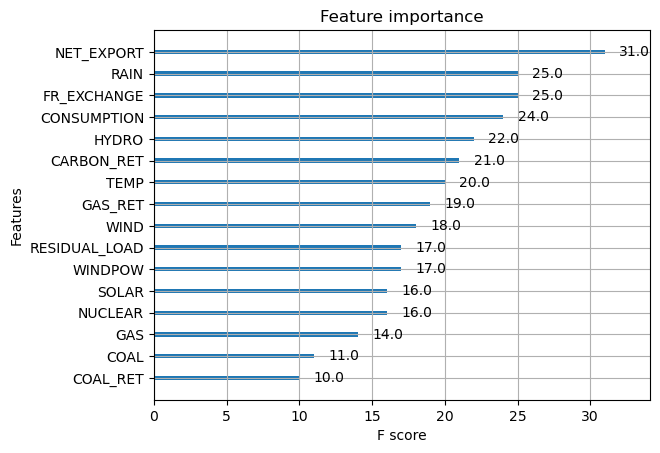

In [19]:
xgb.plot_importance(de_model)

In [15]:
outputs = de_model.predict(test_d)

### Evaluation and output

In [16]:
from scipy.stats import spearmanr

spearman_ = spearmanr(outputs, de_test['target']).correlation
pearson_ = np.corrcoef(outputs,  de_test['target'])[0,1]

print(f'Spearman: {spearman_}, Pearson: {pearson_}')

Spearman: 0.2553164132379249, Pearson: 0.2534846119831518


In [17]:
output_df = clean_df(x_test, 'de')

output_d = xgb.DMatrix(output_df[inputs])
output_df['predict'] = de_model.predict(output_d)

In [18]:
output_df[['predict']].to_csv('de_out.csv', index_label='ID')

## Takeaways
- Discretization of target variable helps to deal with outliers and high kurtosis
- Stratified train/test split helps addressing outliers and randomness
- Reducing tree depth might prevent overfitting